In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as patches
import torch.nn as nn
import os
import time
import torch
from torch.autograd import Variable
from skimage import io
from skimage.measure.simple_metrics import compare_psnr, compare_mse
import sys  
sys.path.insert(0, 'code')
from utils_train import *
from utils_analysis import *
from DnCNN import *
from BF_CNN import *

# %matplotlib inline


## Load a trained bias-free model
(all analyses below are done with respect to this model)



In [2]:
all_params = {
'epochs': 50,
"learning_rate" : .001,
'parent_included': 'not applicable',
'kernel_size_waves': 'not applicable',

"kernel_size_mid" : 3,
"padding_mid" : 1,
"num_mid_kernels" : 64,
"num_mid_layers" : 20,

"batch_size" : 128,
"patch_size" : (50,50),
"patching_strides" : (10,10),
'scales' : [1,.9,.8,.7],
}

# select the noise range over which model is trained (options: 0-100, ***LIST MORE***). 
l = 0  # lower bound of training range 
h = 100 # higher bound of training range

folder_path = 'models/BF_CNN/range_'+str(l)+'_'+str(h)+'/results'

## model without bias: BF_CNN
BF_CNN = bf_cnn(all_params)
BF_CNN.load_state_dict(torch.load('models/BF_CNN/range_'+str(l)+'_'+str(h)+'/model.pt',map_location='cpu' ))    
running_sd = torch.load('models/BF_CNN/range_'+str(l)+'_'+str(h)+'/running_sd.pt', map_location='cpu')
for i in range(all_params['num_mid_layers']-2):
    BF_CNN.running_sd[i] = running_sd[i]    
BF_CNN.eval();




In [3]:
# Datasets available in the data folder
train_folder_path = 'data/Train400/'
test_folder_path = 'data/Test/Set68/'
set12_path = 'data/Test/Set12/'
kodak_path = 'data/Test/Kodak23/' 


## Load a test image
(all analyses below are done with respect to this image)



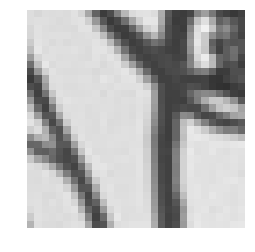

In [4]:
# % matplotlib inline

# Select an image you want to denoise from the test set
image_num = 15
clean_im = single_image_loader(test_folder_path, image_num)
clean_im = clean_im[ 100:130, 100:130]
dim1, dim2 = clean_im.shape
f , axs = plt.subplots(1,1 , figsize=(4,4))    
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


# Interpretation: Nonlinear adaptive filtering

For three different levels of noise, examine adaptive filters used to estimate specific output pixels



In [5]:
#### If you want to use another patch, uncomment this code to calculate the Jacobian of the new image ####
#### Otherwise, skip this step ####

# noise_levels = [10,30,100]
# for noise_level in noise_levels:
    
#     noisy_im, noise = add_noise(clean_im.reshape(1,dim1,dim2), noise_level, 'S') 
#     inp_test = Variable(torch.FloatTensor(noisy_im).unsqueeze(1), volatile = True,requires_grad=False)
#     residual= BF_CNN(inp_test).data.squeeze(0).squeeze(0).numpy()
#     noisy_im = noisy_im.reshape(dim1,dim2)
#     denoised = noisy_im - residual.reshape(dim1,dim2)
    
#     A = calc_jacobian(noisy_im, BF_CNN, all_params)
    
#     np.save(folder_path + '/noisy_im_'+str(noise_level)+'.npy', noisy_im)
#     np.save(folder_path + '/im_denoised_'+str(noise_level)+'.npy', denoised)
#     np.save(folder_path + '/Jacobian_'+str(noise_level)+'.npy', A)


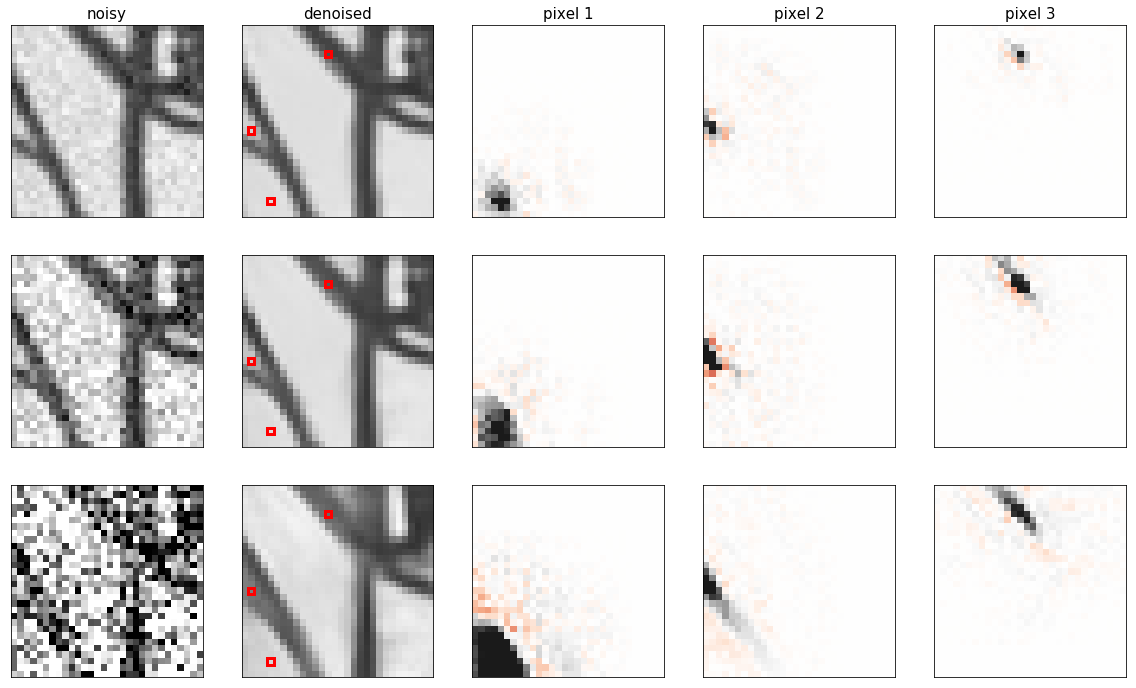

In [6]:

# %matplotlib inline
noise_levels = [10,30,100]

pixels_rows = [27, 16, 4]
pixels_cols = [4 , 1 ,13]

f , axs = plt.subplots(len(noise_levels),2+len(pixels_rows) , figsize=(20,12))
for j in range(len(noise_levels)): 
    A = np.load(folder_path + '/Jacobian_'+str(noise_levels[j])+'.npy')
    noisy_im = np.load(folder_path + '/noisy_im_'+str(noise_levels[j])+'.npy')
    denoised = np.load(folder_path + '/im_denoised_'+str(noise_levels[j])+'.npy')

    
    dim1, dim2 = noisy_im.shape
    N = A.shape[0]
    I = np.eye(N) 

    axs[j,0].imshow(noisy_im, 'gray', vmin = 0, vmax = 1)
    axs[j,0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

    axs[j,1].imshow(denoised, 'gray', vmin = 0, vmax = 1)
    axs[j,1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
        
    for r,c in zip(pixels_rows, pixels_cols): 
        pa = patches.Rectangle((c-.5,r-.5), width=1, height=1, angle=0.0, edgecolor = [1,0,0], facecolor='none', lw=3)
        axs[j, 1].add_patch(pa)
        
    for p in range(len(pixels_cols)):     
        r = pixels_rows[p]
        c = pixels_cols[p]
        limit =  max(np.abs(np.min( (I - A)[dim1*r+c ,:])), np.abs(np.max( (I - A)[dim1*r+c,:])))/2
        axs[j,p+2].imshow((I - A)[dim1*r+c,:].reshape(dim1,dim2), 'RdGy', vmin = -limit, vmax = limit)
        axs[j,p+2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

axs[0,0].set_title('noisy', fontsize=15)
axs[0,1].set_title('denoised', fontsize=15)
axs[0,2].set_title('pixel 1', fontsize=15)
axs[0,3].set_title('pixel 2', fontsize=15)
axs[0,4].set_title('pixel 3', fontsize=15);
        
        

<IPython.core.display.Javascript object>


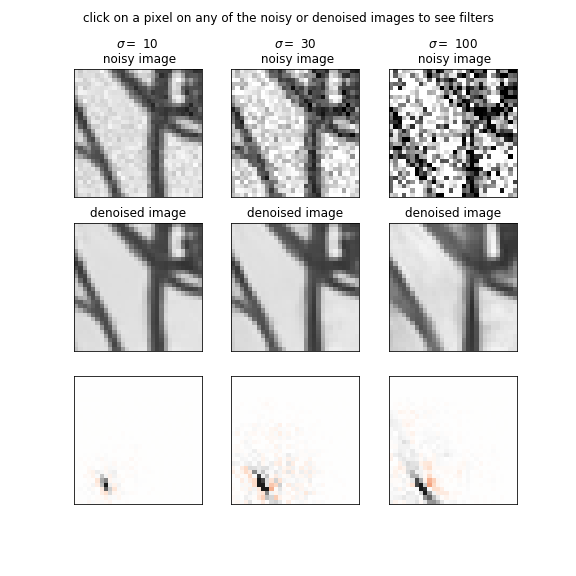

In [22]:
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
fig.suptitle('Click on a pixel location in any noisy or denoised image to see corresponding adaptive filters')
plt.axis('off')
for j in range(len(noise_levels)): 
    noisy_im = np.load(folder_path + '/noisy_im_'+str(noise_levels[j])+'.npy')
    
    ax = fig.add_subplot(3,3,j+1)
    ax.imshow(noisy_im, 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title(r'$\sigma = $ ' + str(noise_levels[j]) + '\n noisy image')
    
for j in range(len(noise_levels)): 
    denoised = np.load(folder_path + '/im_denoised_'+str(noise_levels[j])+'.npy')
    
    ax = fig.add_subplot(3,3,j+4)
    ax.imshow(denoised, 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title( 'denoised image')




ix, iy = 13, 4
def onclick(event):
    global ix, iy
    ix, iy = int(event.xdata), int(event.ydata)
    
    for j in range(len(noise_levels)): 
        A = np.load(folder_path + '/Jacobian_'+str(noise_levels[j])+'.npy')
        ax = fig.add_subplot(fig.add_subplot(3,3,j+7))
        limit =  max(np.abs(np.min( (I - A)[dim1*r+c ,:])), np.abs(np.max( (I - A)[dim1*r+c,:])))/2
        ax.imshow((I - A)[dim1*iy+ix,:].reshape(dim1,dim2), 'RdGy', vmin = -limit, vmax = limit)
        ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)


cid = fig.canvas.mpl_connect('button_press_event', onclick)




In [8]:
# run this to exit the interactive mode
f.canvas.mpl_disconnect(cid)


# Interpretation: Projection onto adaptive signal subspace

Compute SVD of network Jacobian, evaluated at current image



<IPython.core.display.Javascript object>


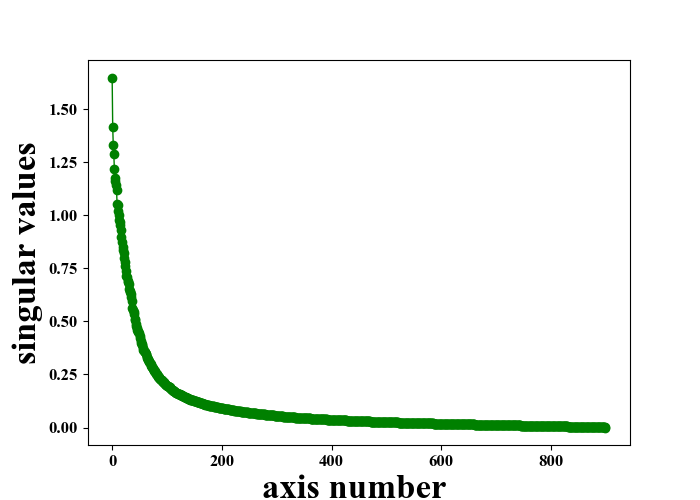

In [11]:
% matplotlib inline

U , S, V = np.linalg.svd(I - A)
f, ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(S, '-o',alpha = 1,label='singular value', color = 'green', linewidth=1)

ax.set_xlabel('axis number ', fontsize = 25, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 25, fontname= 'Times New Roman')   

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    tick.label.set_fontname("Times New Roman")


## Select some singular vectors for visualization.
Those with singular values near 1 are axes of the preserved (signal) subspace.
Those with singular values near 0 are axes of the discarded (noise) subspace.



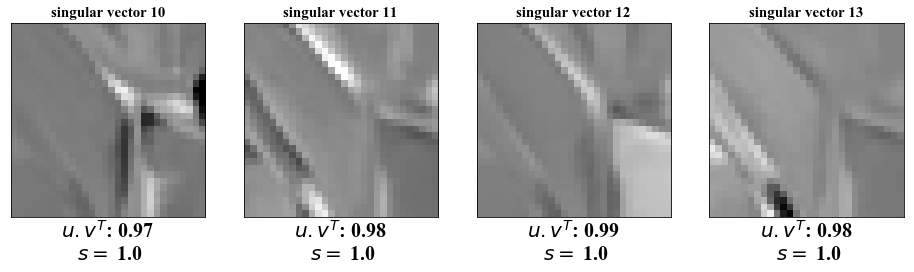

In [16]:
% matplotlib inline

sing_vect_n = [10,11,12,13]

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))


f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(16,4))    
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 15, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$u.v^T$: '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 20, fontname= 'Times New Roman')




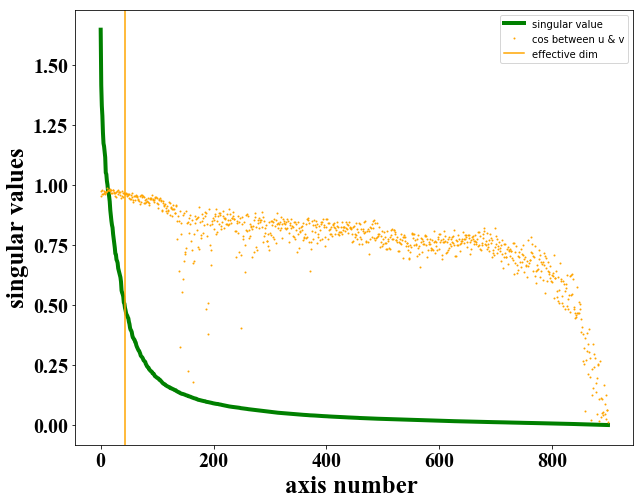

In [17]:
# % matplotlib inline

# show the singular vectors, highlight teh singular value s

subspace_dim = int(np.sum((S)**2))

uvdots = []
for j in range(N):
    v = V[j,:]
    u = U[:,j]
    uvdots.append(abs(np.dot(v,u)))


f, ax = plt.subplots(1,1,figsize = (10,8))

ax.plot(S, alpha = 1, label='singular value', color = 'green', linewidth=4)
ax.plot(uvdots, '.', color = 'orange', markersize=2, label = 'cos between u & v')   
ax.axvline(subspace_dim, color='orange', alpha = 1, label = 'effective dim')     


ax.set_xlabel('axis number ', fontsize = 25, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 25, fontname= 'Times New Roman')   
plt.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_fontname("Times New Roman")




## Subspace dimensionality as a function of noise, across many images



If you want to use a new set of patches, run calc_subspace_dims.py module from the code directory to calculate the dimensionalities of subspaces of new images.
Otherwise, skip this step, and load the existing results. 


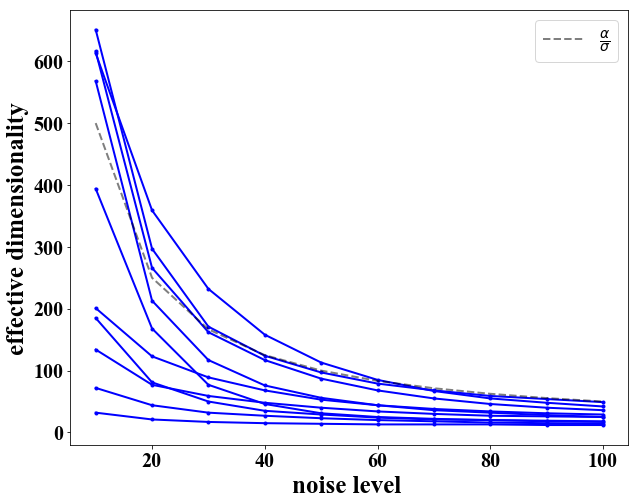

In [18]:
# % matplotlib inline

subspace_dims = np.load(folder_path + '/subspace_dims.npy').item()

f, ax = plt.subplots(1,1,figsize = (10,8))

for i, dims in subspace_dims.items():
    ax.plot(range(10,110,10), dims, alpha = 1, linewidth=2, marker = '.', color='blue')

ax.set_xlabel('noise level ',fontsize = 25, fontname= 'Times New Roman')
ax.set_ylabel('effective dimensionality', fontsize = 25, fontname= 'Times New Roman')   
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    tick.label.set_fontname("Times New Roman")

ax.plot(range(10,110,10), [(5000/x) for x in range(10,110,10)], 'k--', lw = 2, label = r'$\frac{\alpha}{\sigma}$', alpha = .5)    
ax.legend(fontsize=20)
